<a href="https://colab.research.google.com/github/pingvinnen/100-redteam-projects/blob/master/Lab_03_regression_KHA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1 style="font-size:40px;">Regression</h1></center>

Welcome to the third lab in the Deep learning course! In this lab we will continue to take a look at four parts for MLP regression;
* Introduction for setup and train an MLP
* Model selection for classification
* Impact of overfitting in validation performance
* Avoid overfitting for a regression problem

The lab includes different datasets, both synthetic and real for regression task.
The first part of the lab uses two different synthetic regression problems. The **regr1()** synthetic dataset is a two-dimensional dataset with linear and non-linear relationships between the input features and the output value. It is a good benchmark dataset for regression models, as it is challenging and realistic. The **generate_piecewise_linear_data()** function generates a synthetic dataset with piecewise linear relationships between the input features and the output value with varying amount of noise for each piece.

All **Tasks** include **TODO's** these are expected to be done before the deadline for this lab. The **Tasks** also include question(s), which should be answered and included in the report. Some sections do not contain any **TODO's** but are good to understand.

Good luck!

---

## Intro to regression


The regression task is to learn a function f that maps from a set of input features X to a continuous output value y. The input features X can be either real-valued or categorical. The output value y is a real-valued number.

$$
y = f(X) + \epsilon
$$

The regression model is trained on a set of training data points, where the input features and the output values are known. The model learns to identify the relationship between the input features and the output values, and then uses this relationship to predict the output value for new input features.



## Necessary Imports

In [41]:
# select gpu by index in case of multiple gpus
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import copy

## Let's use GPU if possible

In [43]:
# set device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

## Dataset generator

In [44]:
class MLPData:
    """
    This class will manage all the dataset related functions for this lab.
    Please take the time do go through the code and try to understand how each point is generated
    """

    @staticmethod
    def regr1(N, v=0):
        """data(samples, features)

        :param N: param v:  (Default value = 0)
        :param v: Default value = 0)

        """
        data = np.empty(shape=(N, 2), dtype=np.float64)

        uni = lambda n: np.random.uniform(0, 1, n)
        norm = lambda n: np.random.normal(0, 1, n)
        noise = lambda n: np.random.normal(0, 1, (n,))
        data[:, 0] = norm(N)
        data[:, 1] = uni(N)

        tar = 10 * data[:, 0] + np.sin(20 * np.pi * data[:, 1])
        std_signal = np.std(tar)
        no = noise(N)
        tar = tar + v * std_signal * no
        return data, tar

    @staticmethod
    def generate_piecewise_linear_data(n_samples, n_segments, stocastic_noise=False):
        """
        Generates a piecewise linear dataset with n_segments segments.
        :param n_samples: Number of samples to generate
        :param n_segments: Number of segments to use
        :return: x, y

        """
        x = torch.rand(n_samples) * 10  # Generate random input values between 0 and 10
        y = torch.zeros(n_samples)

        segment_length = 10 / n_segments
        for i in range(n_segments):
            mask = (x >= i * segment_length) & (x < (i + 1) * segment_length)
            slope = torch.randn(1) * 2  # Random slope for each segment
            if stocastic_noise:
                noise = torch.randn(sum(mask)) * (0.5 + i * torch.randn(1))
            else:
                noise = torch.randn(sum(mask)) * (
                    0.5 + i * 0.2
                )  # Heteroscedastic noise
            y[mask] = slope * x[mask] + noise

        return x, y

Do not forget to instanciate an object of the above class for you to be able to generate dataset on the fly!

In [45]:
synthetic_datasets = MLPData()

Let's see how each dataset looks like!

In [46]:
def data_distribution(imgs, shape=(2, 2)):
    """Plot scatter distribution for a list of images."""
    f, axs = plt.subplots(*shape, figsize=(10, 10))
    axs = axs.flatten()

    if isinstance(imgs, list):
        for idx, ((d, t), ax) in enumerate(zip(imgs, axs)):
            ax.scatter(d[:, 0], d[:, 1], c=t)
            ax.set_title(f"Plot number: {idx}")
    elif isinstance(imgs, dict):
        for (key, (d, t)), ax in zip(imgs.items(), axs):
            ax.scatter(d[:, 0], d[:, 1], c=t)
            ax.set_title(key)
    plt.show()

In [47]:
## Plotting synthetic datasets
# make sure you understand how the data is generated

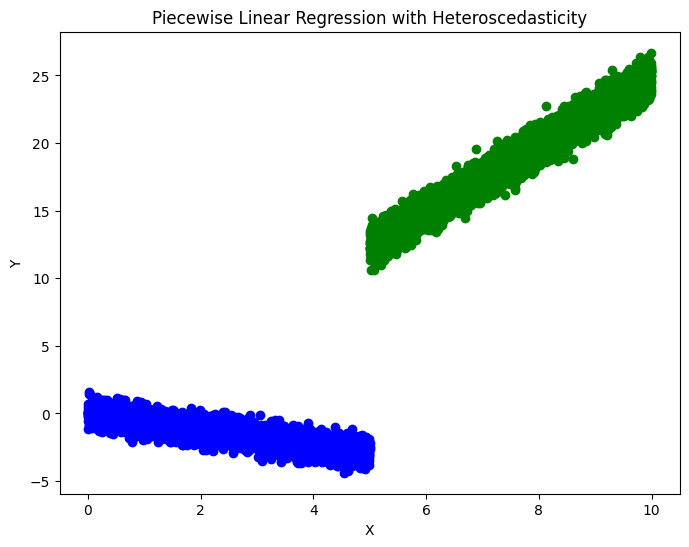

In [48]:
# Generate the synthetic dataset
n_samples = 10000
n_segments = 2
x, y = synthetic_datasets.generate_piecewise_linear_data(
    n_samples, n_segments, stocastic_noise=False
)

# Define colors for each segment
segment_colors = [
    "b",
    "g",
    "r",
    "c",
    "m",
] * (
    n_segments // 5 + 1
)  # Repeat the colors to have enough colors for each segment (up to 5 segments

# Plot the synthetic data with different colors for each segment
plt.figure(figsize=(8, 6))
for i in range(n_segments):
    mask = (x >= i * (10 / n_segments)) & (x < (i + 1) * (10 / n_segments))
    plt.scatter(x[mask], y[mask], label=f"Segment {i+1}", c=segment_colors[i])

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Piecewise Linear Regression with Heteroscedasticity")
plt.show()

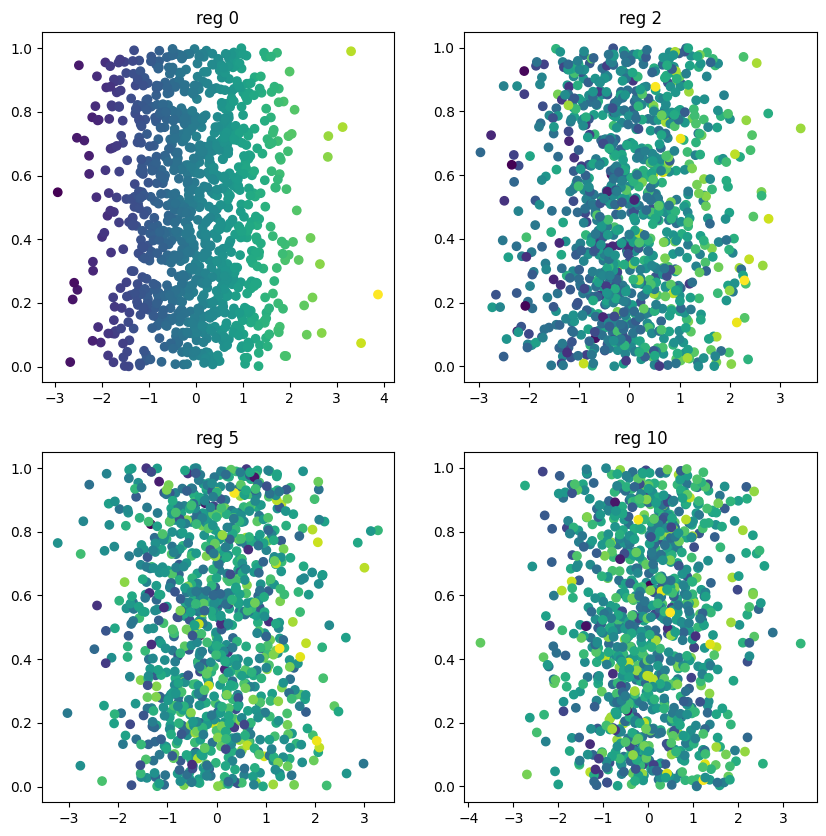

In [49]:
data_distribution(
    {
        "reg 0": MLPData.regr1(1000, v=0),
        "reg 2": MLPData.regr1(1000, v=2),
        "reg 5": MLPData.regr1(1000, v=5),
        "reg 10": MLPData.regr1(1000, v=10),
    },
    shape=(2, 2),
)

## Task 1

**Model definition**

In this lab exercise, you will design a Multi-Layer Perceptron (MLP) for regression. The goal is to create a simple neural network architecture to predict a continuous target variable based on input features. By completing this exercise, you will gain hands-on experience in configuring the architecture of an MLP for regression tasks.

    Task Description:

- Create an MLP architecture for regression.
- Define the input layer, hidden layers, and output layer.
- Configure the input layer to accept input data with dimensions specified as in_dimension.
- Design the hidden layers with num_hidden_layers layers and hidden_nodes neurons in each layer.
- Choose an appropriate activation function, specified as act, for the hidden layers. You can use common activation functions like ReLU (torch.nn.ReLU) for this purpose.
- Configure the output layer to have a linear activation function since this is a regression task.
- Define the output dimension to match your regression problem's requirements (specified as out_dimension).

In [50]:
class NeuralNet(torch.nn.Module):
    def __init__(
        self,
        in_dimension=2,
        hidden_nodes=1,
        num_hidden_layers=1,
        act=torch.nn.ReLU(inplace=True),
        out_dimension=1,
    ):
        super(NeuralNet, self).__init__()
        # TODO: define the layers
        layers = [torch.nn.Linear(in_dimension, hidden_nodes), torch.nn.ReLU()]
        for _ in range(num_hidden_layers - 1):
            layers.append(torch.nn.Linear(hidden_nodes, hidden_nodes))
            layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Linear(hidden_nodes, out_dimension))
        self.model = torch.nn.Sequential(*layers)


    def forward(self, x):
      return self.model(x)

## Process the data for training

We need to make tensor from the numpy data generated from ```MLPData``` class and use them to create a PyTorch dataset. For this exercise we will use ```TensorDataset```. To iterate over the dataset, we need a data loader. We will use the default ```DataLoader```. You can find the corresponding documentation [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) and [here](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)

In [51]:

x, y = synthetic_datasets.regr1(10000)
#  array to a Tensor
x = torch.Tensor(x)
y = torch.Tensor(y.squeeze())
# TensorDataset
syn2_Pytorch = TensorDataset(x, y)
#  dataloader.
loader = DataLoader(syn2_Pytorch, batch_size=1024)

# Task 2

Finish the below function. The task at this point is to create a function that is able to train your ```model``` for ```epoch_number``` using ```optimizer```, ```loss``` and ```dataloader```. You can read about optimizer [here](https://pytorch.org/docs/stable/optim.html)

In [52]:
def train_epoch(epoch, optimizer, loss_fx, model, train_loader):
    model.train()  # Sets the model to training mode
    total_loss = 0
    for batch_idx, (xi, yi) in enumerate(train_loader):
        xi, yi = xi.to(device), yi.to(device)
        optimizer.zero_grad()  # Clear gradients
        output = model(xi)  # Forward pass
        loss = loss_fx(output, yi)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        total_loss += loss.item()  # Track loss
    return total_loss / len(train_loader)  # Average loss


Now that we have a way to trian our model, we need to create an instance of the model and train it. We still need a way to evaluate our model. In this simple datasets, we can try to visualize the decision boundaries.

We will create one ```helper function```: ```plot_decision_boundary```

In [53]:
def plot_decision_boundary(dataset, y, model, steps=50):
    xmin, xmax = dataset[:, 0].min(), dataset[:, 0].max()
    ymin, ymax = dataset[:, 1].min(), dataset[:, 1].max()
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx_pred, yy_pred = np.meshgrid(x_span, y_span)
    model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

    # To make predictions across region of interest
    model.eval()
    labels_predicted = model(Variable(torch.Tensor(model_viz)).float())

    labels_predicted = labels_predicted.detach().numpy()

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.scatter(dataset[:, 0], dataset[:, 1], y)
    ax.scatter(
        xx_pred.flatten(),
        yy_pred.flatten(),
        labels_predicted,
        facecolor=(0, 0, 0, 0),
        s=20,
        edgecolor="#70b3f0",
    )
    ax.view_init(elev=28, azim=120)
    plt.show()
    model.train()
    return fig, ax

In [54]:
def stats_reg(x, y, model):
    """
    Returns the MSE and CorrCoef for a given dataset and y
    """

    A = ["MSE", "CorrCoeff"]
    model.eval()
    preds = model(x)
    pcorr = np.corrcoef(y.flatten(), preds.detach().numpy().flatten())
    mse = torch.nn.MSELoss()(preds, y)

    B = [mse.item(), pcorr]

    print(f"\n {'#'*20} STATISTICS{'#'*20}\n")
    for r in zip(A, B):
        print(*r, sep="   ")
    return print(f"\n {'#'*50}")

## Task 3

### Instantiation
Now the only thing missing to visualize you results is a trained network. **TODO:** Instantiate your model, loss and optimizer below. The choice of loss is critical for the training.  

In [55]:
my_model = NeuralNet(in_dimension=2, hidden_nodes=64, num_hidden_layers=2, out_dimension=1).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.001)


### Train the model

Now, our model, loss and optimizer are setup and we are ready to go Training

In [56]:
num_epoch = 1000
train_losses = list()
for epoch in range(1, num_epoch + 1):
    epoch_loss = train_epoch(epoch, optimizer, criterion, my_model, loader)
    train_losses.append(epoch_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1}/{num_epoch}: Loss = {epoch_loss}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([784])) that is different to the input size (torch.Size([784, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 11/1000: Loss = 101.04368362426757
Epoch 21/1000: Loss = 101.04292068481445
Epoch 31/1000: Loss = 101.04258651733399
Epoch 41/1000: Loss = 101.04234924316407
Epoch 51/1000: Loss = 101.04217834472657
Epoch 61/1000: Loss = 101.04204177856445
Epoch 71/1000: Loss = 101.04191207885742
Epoch 81/1000: Loss = 101.04180374145508
Epoch 91/1000: Loss = 101.04169158935547
Epoch 101/1000: Loss = 101.04158325195313
Epoch 111/1000: Loss = 101.04147796630859
Epoch 121/1000: Loss = 101.04140396118164
Epoch 131/1000: Loss = 101.04133682250976
Epoch 141/1000: Loss = 101.04126892089843
Epoch 151/1000: Loss = 101.04121856689453
Epoch 161/1000: Loss = 101.04116668701172
Epoch 171/1000: Loss = 101.04111938476562
Epoch 181/1000: Loss = 101.0410758972168
Epoch 191/1000: Loss = 101.04103164672851
Epoch 201/1000: Loss = 101.04098815917969
Epoch 211/1000: Loss = 101.04095458984375
Epoch 221/1000: Loss = 101.04092178344726
Epoch 231/1000: Loss = 101.04088668823242
Epoch 241/1000: Loss = 101.04085693359374
Ep

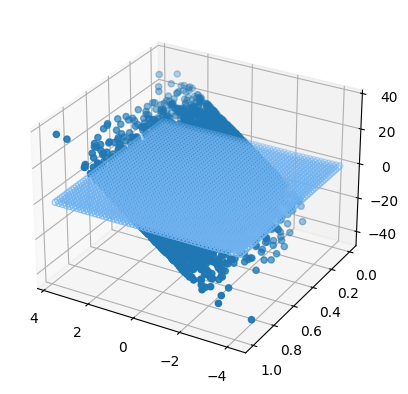

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

In [57]:
plot_decision_boundary(x, y, my_model, steps=50)

In [58]:
stats_reg(x, y, my_model)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([10000])) that is different to the input size (torch.Size([10000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



 #################### STATISTICS####################

MSE   101.00030517578125
CorrCoeff   [[1.        0.5927057]
 [0.5927057 1.       ]]

 ##################################################


## Visualize the train losses

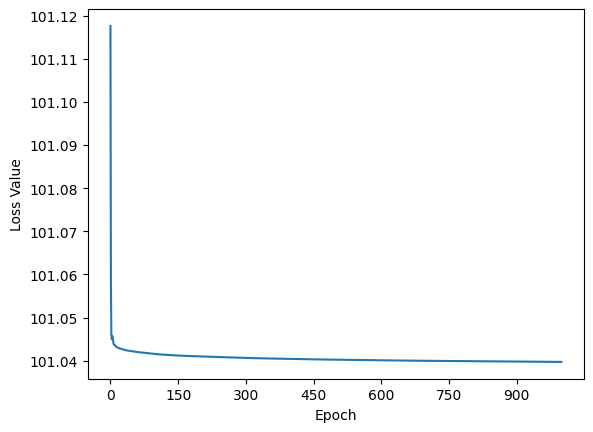

In [59]:
ax = plt.figure().gca()
plt.plot(np.arange(len(train_losses)), train_losses)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.show()

## Model Selection

A proper training procedure is divided into ```3 splits```: training, validation and test. Generally, for each epoch, training is done on training data, and then a validation is done on the validation data. During validation the model weights are not updated. Best performing model on the validaiton data is selected and saved for final evaluation on test data.

## Task 4

**TODO:** Split the data to 3 parts, one for training, one for validation and one hold out set for testing. A good starting point can be 70%, 15% and 15% of the dataset respectively for each split

**HINT** you can either do this manually with indexing or use readily available tools e.g. in sklearn

In [60]:
from sklearn.model_selection import train_test_split

x, y = synthetic_datasets.regr1(10000)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
valid_dataset = TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid))
test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)


## Task 5
**TODO:** Complete the following functions. Run a proper training on each of the synthetic datasets you have created. Discuss the performance of model in report. What could be the reason behind the performance? Feel free to adapt the number of hidden nodes (and possibly the number of hidden layers and epochs)

In [61]:
def validate_epoch(loss_fn, model, val_loader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (xi, yi) in enumerate(val_loader):
            xi, yi = xi.to(device), yi.to(device)
            output = model(xi)
            loss = loss_fn(output, yi)
            total_loss += loss.item()
    return total_loss / len(val_loader)


In [62]:
def a_proper_training(num_epoch, model, optimizer, loss_fn, train_loader, val_loader):
    """
    Performs a complete training and validation process for the given model.
    """
    best_val_loss = float('inf')  # Initialize to a large value
    best_model = None
    train_losses = []
    val_losses = []

    for epoch in range(num_epoch):
        # Training step
        train_loss = train_epoch(epoch, optimizer, loss_fn, model, train_loader)
        # Validation step
        val_loss = validate_epoch(loss_fn, model, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # saving the model with the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)  # Making a deep copy of the model

        print(f"Epoch {epoch + 1}/{num_epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # Returning the best model and the lists of training/validation losses
    return best_model, train_losses, val_losses


In [63]:
# TODO: instantiate model
my_model = NeuralNet(in_dimension=2, hidden_nodes=64, num_hidden_layers=2, out_dimension=1).to(device)

# TODO: instantiate loss
criterion = torch.nn.MSELoss()

# TODO: instantiate a suitable optimizer
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.001)


In [64]:
best_model, train_losses, val_losses = a_proper_training(
    1000, my_model, optimizer, criterion, train_loader, valid_loader
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([856])) that is different to the input size (torch.Size([856, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([476])) that is different to the input size (torch.Size([476, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/1000: Train Loss = 100.5992, Val Loss = 96.2183
Epoch 2/1000: Train Loss = 100.4804, Val Loss = 96.2634
Epoch 3/1000: Train Loss = 100.4758, Val Loss = 96.2917
Epoch 4/1000: Train Loss = 100.5832, Val Loss = 96.2793
Epoch 5/1000: Train Loss = 100.5205, Val Loss = 96.2747
Epoch 6/1000: Train Loss = 100.4695, Val Loss = 96.2614
Epoch 7/1000: Train Loss = 100.5969, Val Loss = 96.2523
Epoch 8/1000: Train Loss = 100.4389, Val Loss = 96.2508
Epoch 9/1000: Train Loss = 100.5300, Val Loss = 96.2579
Epoch 10/1000: Train Loss = 100.5391, Val Loss = 96.2588
Epoch 11/1000: Train Loss = 100.5241, Val Loss = 96.2752
Epoch 12/1000: Train Loss = 100.5219, Val Loss = 96.2772
Epoch 13/1000: Train Loss = 100.5332, Val Loss = 96.2655
Epoch 14/1000: Train Loss = 100.6929, Val Loss = 96.2769
Epoch 15/1000: Train Loss = 100.5351, Val Loss = 96.2555
Epoch 16/1000: Train Loss = 100.5509, Val Loss = 96.2511
Epoch 17/1000: Train Loss = 100.5398, Val Loss = 96.2619
Epoch 18/1000: Train Loss = 100.5878, Va

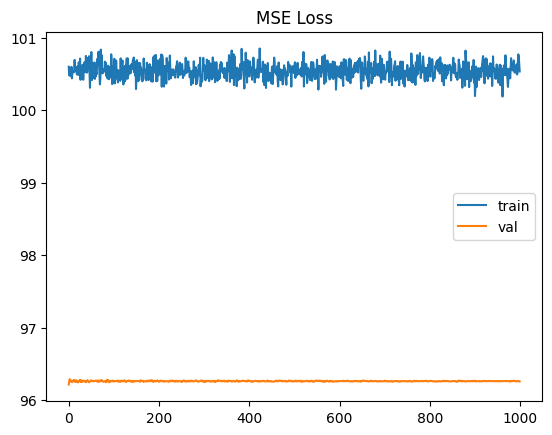

In [65]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.title("MSE Loss")
plt.legend()

## Task 6

Add dropout to the model, and rerun the previous experiment, does it have any effect and why?

In [66]:
class NeuralNetWithDropout(torch.nn.Module):
    def __init__(self, in_dimension=2, hidden_nodes=64, num_hidden_layers=2, dropout_prob=0.5, out_dimension=1):
        super(NeuralNetWithDropout, self).__init__()
        layers = [torch.nn.Linear(in_dimension, hidden_nodes), torch.nn.ReLU(), torch.nn.Dropout(dropout_prob)]
        for _ in range(num_hidden_layers - 1):
            layers.append(torch.nn.Linear(hidden_nodes, hidden_nodes))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(dropout_prob))
        layers.append(torch.nn.Linear(hidden_nodes, out_dimension))
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)



## Task 7


**TODO!** Rerun the experiment with the second synthetic dataset, with splitting, and proper training. Feel free to play with the parameters of the models

In [67]:

# Generate the synthetic dataset
n_samples = 10000
n_segments = 5
X, y = synthetic_datasets.generate_piecewise_linear_data(
    n_samples, n_segments, stocastic_noise=True
)
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% valid, 15% test

train_dataset = TensorDataset(torch.Tensor(X_train).unsqueeze(1), torch.Tensor(y_train))
valid_dataset = TensorDataset(torch.Tensor(X_valid).unsqueeze(1), torch.Tensor(y_valid))
test_dataset = TensorDataset(torch.Tensor(X_test).unsqueeze(1), torch.Tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [68]:
# TODO: instantiate model
my_model = NeuralNet(in_dimension=1, hidden_nodes=14, num_hidden_layers=1)
# TODO: instantiate loss
critereon = nn.MSELoss()
# TODO: instantiate a suitable optimizer
optimizer = Adam(my_model.parameters(), lr=0.001)

In [69]:
best_model, train_losses, val_losses = a_proper_training(
    10000, my_model, optimizer, critereon, train_loader, valid_loader
)

Streaming output truncated to the last 5000 lines.
Epoch 5001/10000: Train Loss = 64.5082, Val Loss = 64.6955
Epoch 5002/10000: Train Loss = 64.6906, Val Loss = 64.6940
Epoch 5003/10000: Train Loss = 64.5300, Val Loss = 64.6917
Epoch 5004/10000: Train Loss = 64.6533, Val Loss = 64.6911
Epoch 5005/10000: Train Loss = 64.5455, Val Loss = 64.7034
Epoch 5006/10000: Train Loss = 64.6136, Val Loss = 64.7138
Epoch 5007/10000: Train Loss = 64.6230, Val Loss = 64.7120
Epoch 5008/10000: Train Loss = 64.6673, Val Loss = 64.6929
Epoch 5009/10000: Train Loss = 64.6103, Val Loss = 64.6909
Epoch 5010/10000: Train Loss = 64.4907, Val Loss = 64.6931
Epoch 5011/10000: Train Loss = 64.6507, Val Loss = 64.6942
Epoch 5012/10000: Train Loss = 64.6999, Val Loss = 64.6993
Epoch 5013/10000: Train Loss = 64.7194, Val Loss = 64.6984
Epoch 5014/10000: Train Loss = 64.6243, Val Loss = 64.6962
Epoch 5015/10000: Train Loss = 64.5615, Val Loss = 64.6909
Epoch 5016/10000: Train Loss = 64.7544, Val Loss = 64.6978
Epoch

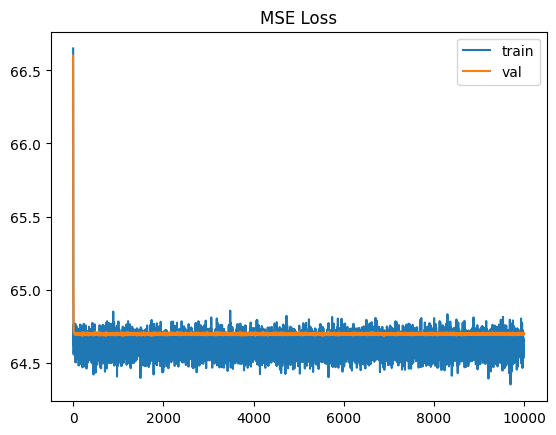

In [70]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.title("MSE Loss")
plt.legend()

In [71]:
def stats_reg(dataloader, model):
    """
    Returns the MSE and CorrCoef for a given PyTorch dataset and model
    """

    A = ["MSE", "CorrCoeff"]
    model.eval()

    for x, y in dataloader:
        preds = model(x)
        pcorr = np.corrcoef(y.flatten(), preds.detach().numpy().flatten())
        mse = nn.MSELoss()(preds, y)

    B = [mse.item(), pcorr[0, 1]]

    print(f"\n {'#'*20} STATISTICS{'#'*20}\n")
    for r in zip(A, B):
        print(*r, sep="   ")
    return print(f"\n {'#'*50}")

In [72]:
stats_reg(test_loader, my_model)


 #################### STATISTICS####################

MSE   65.59913635253906
CorrCoeff   0.5362636109087551

 ##################################################


<center><h1 style="font-size:40px;">Real dataset</h1></center>

## Task 8

In the following example, we will import the diabetes dataset. This dataset contains data from diabetic patients and contains certain features such as their bmi, age , blood pressure and glucose levels which are useful in predicting the diabetes disease progression in patients.

Here are the key details of the sklearn diabetes dataset:

- Target Variable: The target variable is a quantitative measure of disease progression, which represents the one-year change in a patient's disease progression. It is a continuous variable, not a binary classification of diabetes.
- Features (Predictors):
    The dataset contains ten baseline variables (predictors) that are used to predict the disease progression:

        - Age
        - Sex
        - BMI (Body Mass Index)
        - Average Blood Pressure
        - S1: Total serum cholesterol
        - S2: Low-density lipoproteins (LDL cholesterol)
        - S3: High-density lipoproteins (HDL cholesterol)
        - S4: Total cholesterol / HDL cholesterol ratio
        - S5: Log of serum triglycerides level
        - S6: Blood sugar level

In [73]:
from sklearn import datasets
import seaborn as sns
import pandas as pd
import numpy as np

In [74]:
diabetes = datasets.load_diabetes(scaled=True, as_frame=True, return_X_y=True)
X, y = diabetes[0], diabetes[1]
X = X.astype(np.float32)
y = y.astype(np.float32)

<Axes: >

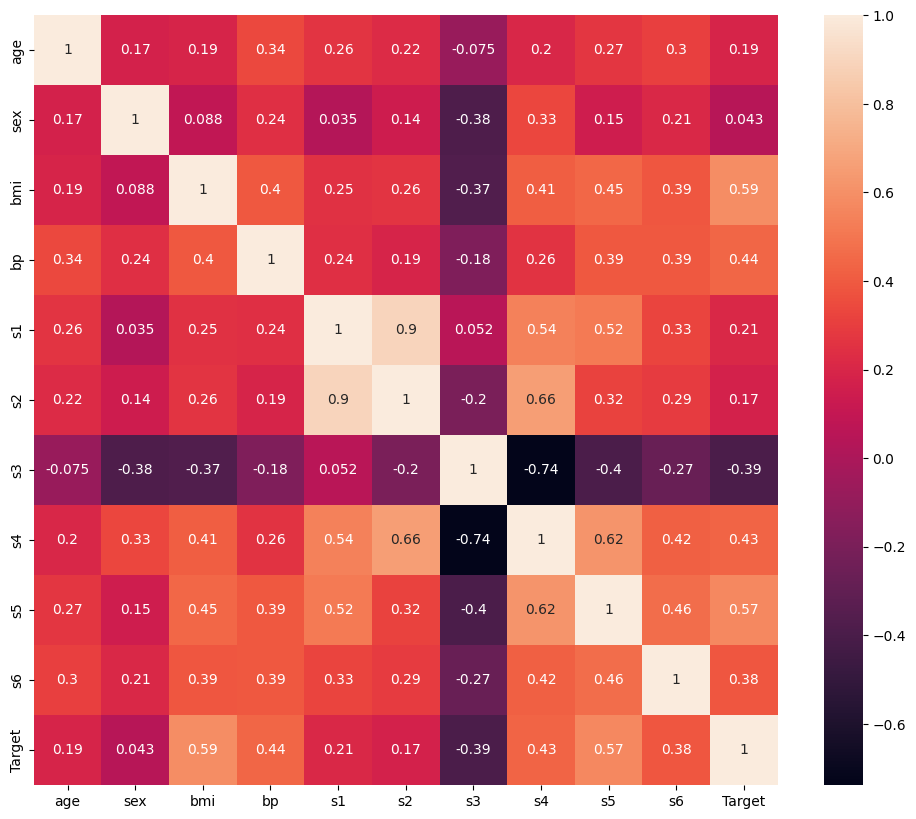

In [75]:
cols = list(X.columns) + ["Target"]
diabetes_df = pd.DataFrame(np.hstack([X, np.atleast_2d(y).T]), columns=cols)
plt.figure(figsize=(12, 10))
sns.heatmap(diabetes_df.corr(), annot=True)

**TODO:**  run the experiments for the diabetes dataset, do you get similar performance? why? Do you suffer from overfitting/underfitting?

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([309])) that is different to the input size (torch.Size([309, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([66])) that is different to the input size (torch.Size([66, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100: Train Loss = 27995.4590, Val Loss = 31737.4941
Epoch 2/100: Train Loss = 27979.0801, Val Loss = 31720.5469
Epoch 3/100: Train Loss = 27962.8223, Val Loss = 31703.6797
Epoch 4/100: Train Loss = 27946.6875, Val Loss = 31687.0664
Epoch 5/100: Train Loss = 27930.5801, Val Loss = 31670.6152
Epoch 6/100: Train Loss = 27914.5000, Val Loss = 31654.1855
Epoch 7/100: Train Loss = 27898.4453, Val Loss = 31637.5977
Epoch 8/100: Train Loss = 27882.3184, Val Loss = 31620.8125
Epoch 9/100: Train Loss = 27866.0293, Val Loss = 31603.8301
Epoch 10/100: Train Loss = 27849.4941, Val Loss = 31586.5859
Epoch 11/100: Train Loss = 27832.7109, Val Loss = 31569.0059
Epoch 12/100: Train Loss = 27815.6152, Val Loss = 31551.0566
Epoch 13/100: Train Loss = 27798.1562, Val Loss = 31532.7207
Epoch 14/100: Train Loss = 27780.3145, Val Loss = 31513.9863
Epoch 15/100: Train Loss = 27762.0117, Val Loss = 31494.6699
Epoch 16/100: Train Loss = 27743.2168, Val Loss = 31474.7578
Epoch 17/100: Train Loss = 27723.

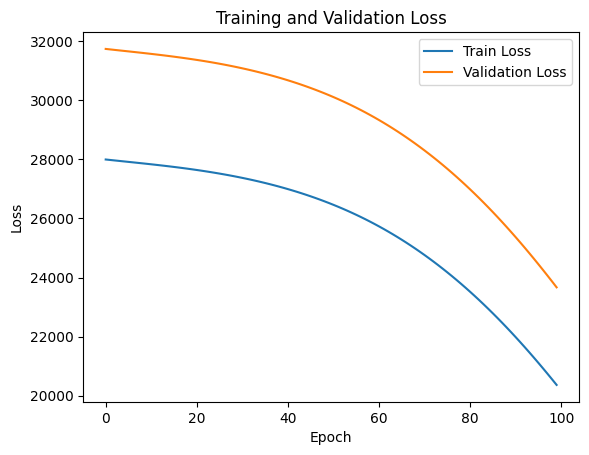

In [76]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import torch

# Loading the diabetes dataset
diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target

# Standardizing the features
X = StandardScaler().fit_transform(X)

# Splitting the data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

# Creating PyTorch datasets and dataloaders
train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
valid_dataset = TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid))
test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Instantiating model, loss, and optimizer
my_model = NeuralNet(in_dimension=X.shape[1], hidden_nodes=64, num_hidden_layers=2, out_dimension=1).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.001)

# Training the model
best_model, train_losses, val_losses = a_proper_training(
    num_epoch=100,
    model=my_model,
    optimizer=optimizer,
    loss_fn=criterion,
    train_loader=train_loader,
    val_loader=valid_loader
)

# Plot for the losses for analysis
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Task 9

**TODO** try applying l1 and l2 regularization, does it help with the performance? Why?

**HINT** in pytorch l2 can be applied by adding weight decay to optimizer, and for adding L1, you can choose HuberLoss instead of MSE. Or feel free to apply them manually

In [77]:
# L2 regularization with Adam optimizer
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 Regularization

# L1 regularization can be manually applied as a penalty in the loss function
def l1_regularization(model, loss, l1_lambda):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return loss + l1_lambda * l1_norm
